In [1]:
# VAE 인코더
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def vae_encoder(latent_dim=2, shape=(28,28,1)):
    inputs = layers.Input(shape=shape)
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, (3,3), activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)

    # 잠재변수의 평균과 로그분산, latend_dim은 MNIST 데이터라면 2(시각화가 쉬움)~10(다양한 특성을 포함)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    model = Model(inputs, [z_mean, z_log_var], name='encoder')
    return model

encoder = vae_encoder()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

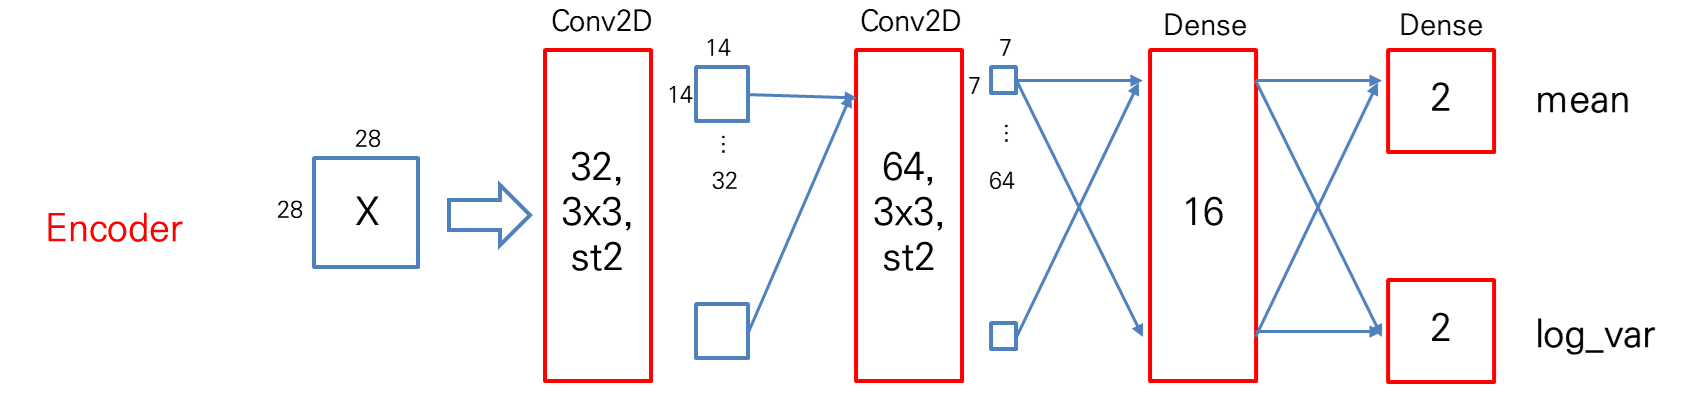

In [3]:
def vae_decoder(latent_dim=2):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7*7*64, activation='relu')(latent_inputs)
    x = layers.Reshape((7,7,64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    model = Model(latent_inputs, outputs)
    return model

decoder = vae_decoder()
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 1)         289   

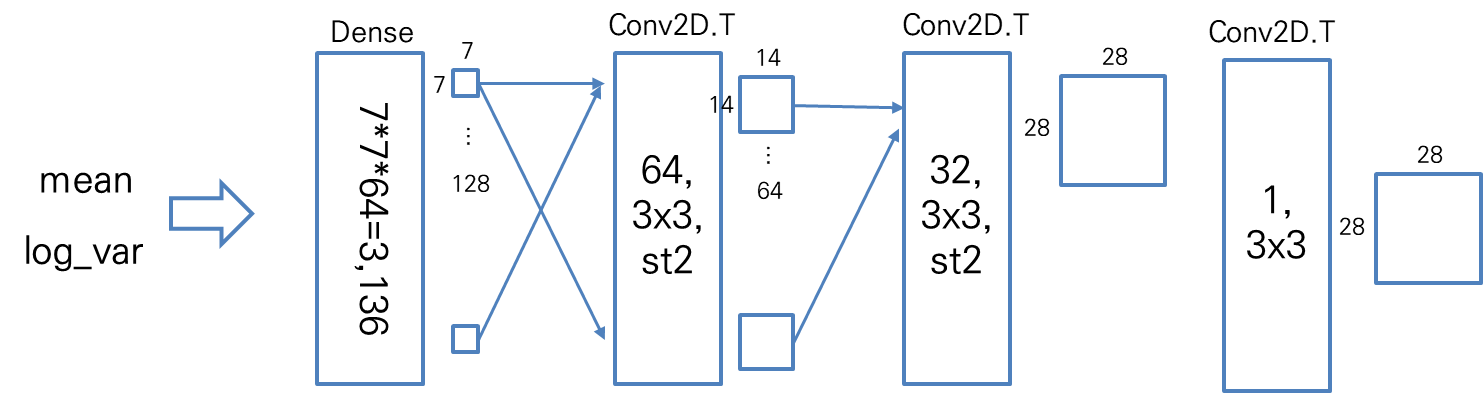

In [4]:
# sampling 함수
import tensorflow as tf

def sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0] #0축은 배치 크기
    dim = tf.shape(z_mean)[1] # 1축은 latent_dim 크기
    # 노이즈를 생성해야 함
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5*z_log_var) * epsilon    # 평균 + 표준편차 * 노이즈

In [6]:
# vae model 정의
inputs = layers.Input(shape=(28,28,1))
z_mean, z_log_var = encoder(inputs)
z = sampling(z_mean, z_log_var)
outputs = decoder(z)
vae_model = Model(inputs, outputs)
vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  69076     ['input_5[0][0]']             
                              (None, 2)]                                                          
                                                                                                  
 tf.compat.v1.shape_2 (TFOp  (2,)                         0         ['encoder[1][0]']             
 Lambda)                                                                                          
                                                                                            

In [7]:
# 데이터 불러오기
from tensorflow.keras.datasets import mnist
import numpy as np
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
X_train = X_train.astype('float32') / 255.0 # 0~1
X_train = np.expand_dims(X_train, -1)
X_test = X_test.astype('float32') / 255
X_test = np.expand_dims(X_test, -1)
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [9]:
# 손실함수 정의
from tensorflow.keras.losses import mse
# 재구성 손실 + KL 손실
def vae_loss(inputs, outputs, z_mean, z_log_var):
    # 재구성 손실
    reconstruction_loss = mse(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= 28*28 # 원래 이미지 크기가 반영되도록 이미지 화소의 개수만큼 곱해줌

    # KL 발산 손실(Kullback-Leibler divergence)
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) # KL 로스 수식을 구현
    kl_loss = tf.reduce_sum(kl_loss, axis=-1) # 각 차원에 대한 합
    kl_loss *= -0.5 # 부호를 맞추기 위해서 조정, KL 발산 조정

    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss) # 최종 손실 계산
    return total_loss

In [10]:
vae_model.add_loss(vae_loss(inputs, outputs, z_mean, z_log_var))
vae_model.compile(optimizer='adam')

In [38]:
vae_model.fit(X_train, epochs=50, batch_size=128, validation_data=(X_test, None))

Epoch 1/50
469/469 [==============================] - 20s 43ms/step - loss: 41.9822 - val_loss: 42.3697
Epoch 2/50
469/469 [==============================] - 20s 43ms/step - loss: 41.9889 - val_loss: 42.2943
Epoch 3/50
469/469 [==============================] - 20s 43ms/step - loss: 41.9581 - val_loss: 42.4543
Epoch 4/50
469/469 [==============================] - 20s 43ms/step - loss: 41.9576 - val_loss: 42.1167
Epoch 5/50
469/469 [==============================] - 20s 43ms/step - loss: 41.9308 - val_loss: 42.3708
Epoch 6/50
469/469 [==============================] - 20s 42ms/step - loss: 41.9177 - val_loss: 42.1517
Epoch 7/50
469/469 [==============================] - 20s 43ms/step - loss: 41.8720 - val_loss: 42.3944
Epoch 8/50
469/469 [==============================] - 20s 43ms/step - loss: 41.8071 - val_loss: 42.0404
Epoch 9/50
337/469 [====================>.........] - ETA: 5s - loss: 41.7555

KeyboardInterrupt: 

1/1 [==============================] - 0s 29ms/step


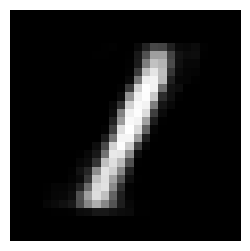

In [37]:
digit = decoder.predict([[11, 2.5]])
# 1, 28, 28, 1
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.imshow(digit[0,...], cmap='gray')
plt.axis('off')
plt.show()

In [22]:
x_test_latent = encoder.predict(X_test)
type(x_test_latent)
x_test_latent = np.array(x_test_latent)
print(x_test_latent.shape)

313/313 [==============================] - 1s 2ms/step
(2, 10000, 2)


In [23]:
x_test_latent1 = x_test_latent[...,0]
print(x_test_latent1.shape)

(2, 10000)


In [24]:
x_test_latent2 = x_test_latent[...,1]
print(x_test_latent2.shape)

(2, 10000)


In [25]:
x = x_test_latent1[0,:]
y = x_test_latent1[1,:]
print(x.shape, y.shape)

(10000,) (10000,)


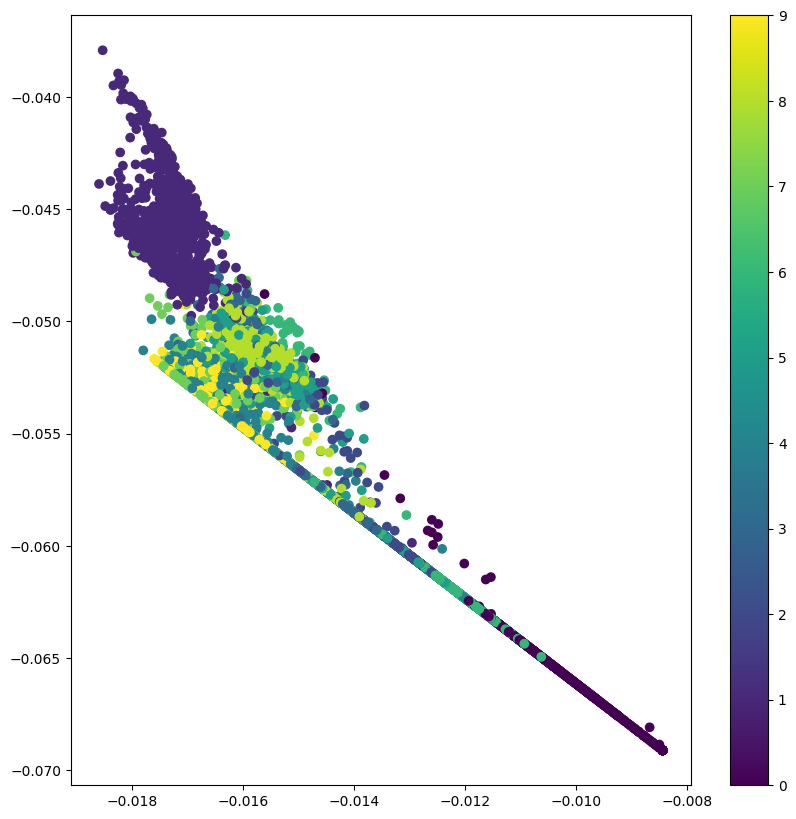

In [26]:
# 잠재벡터 확인

plt.figure(figsize=(10,10))
scatter = plt.scatter(x, y, c=y_test)
plt.colorbar(scatter)
plt.show()

1/1 [==============================] - 0s 15ms/step


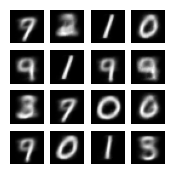

In [52]:
z_test_mean, z_test_log_var = np.array(encoder.predict(X_test[:16,...]))
digits = decoder.predict(sampling(z_test_mean, z_test_log_var))
plt.figure(figsize=(2,2))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(digits[i,...], cmap='gray')
    plt.axis('off')
plt.show()

In [49]:
y_test[:16]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5], dtype=uint8)